In [ ]:
!pip install stellargraph

     |████████████████████████████████| 440kB 5.6MB/s 


In [ ]:
import glob
import itertools
from os.path import join
import pickle
from typing import List
from collections import Counter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sn
import stellargraph as sg
import tensorflow as tf
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, LabelBinarizer
from stellargraph import StellarGraph
from stellargraph.mapper import FullBatchNodeGenerator
from stellargraph.layer import GAT, GCN
from tensorflow.keras import layers, models, optimizers, losses, metrics, Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from torch.utils import data as data_utils
from tqdm import tqdm

from google.colab import drive

tqdm.pandas()

## Setting seed value

In [ ]:
seed_value = 1234

tf.random.set_seed(seed_value)
np.random.seed(seed_value)

## Mount Google Drive

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


## Data loading and preparing

In [ ]:
data = pd.read_csv("/content/drive/Shareddrives/GCN-PROJECT/wiki_pages_lemmas.csv", index_col=0)

In [ ]:
print(data.shape)
data.head()

(75792, 4)


,title,text,category,noun_lemmas
0,Mirosław_Miller,Mirosław Miller – Dyrektor Międzynarodowego La...,Chemia,"['mirosława', 'miller', 'dyrektor', 'laborator..."
1,Chimerokształtne,"Chimerokształtne, chimery, przerazy (Chimaerif...",Biologia,"['chimera', 'przeraza', 'chimaeriformes', 'rzą..."
2,(2855)_Bastian,(2855) Bastian (1931 TB2) – planetoida z grupy...,Astronomia,"['bastian', 'tb2', 'planetoida', 'grupa', 'pas..."
3,Cryptocephalus_celtibericus,"""Cryptocephalus celtibericus"" – gatunek chrząs...",Biologia,"['cryptocephalus', 'celtibericus', 'gatunek', ..."
4,Język_maszynowy,"Język maszynowy, kod maszynowy – zestaw rozkaz...",Matematyka,"['język', 'koda', 'zestaw', 'rozkaz', 'proceso..."


In [ ]:
data = data.drop_duplicates(subset=['title'])
data = data.reset_index(drop=True)

In [ ]:
# noun_lemmas column to list
data['noun_lemmas'] = data['noun_lemmas'].progress_apply(
    lambda row: row[1:-1].replace('\'', '').split(', ')
)

100%|██████████| 75649/75649 [00:01<00:00, 42317.50it/s]


In [ ]:
# Encode target labels with value between 0 and n_classes-1
le = LabelEncoder()
le.fit(data['category'].tolist())
labels = le.transform(data['category'].tolist())

data['category'] = labels

data.head()

,title,text,category,noun_lemmas
0,Mirosław_Miller,Mirosław Miller – Dyrektor Międzynarodowego La...,2,"[mirosława, miller, dyrektor, laboratorium, po..."
1,Chimerokształtne,"Chimerokształtne, chimery, przerazy (Chimaerif...",1,"[chimera, przeraza, chimaeriformes, rząd, ryba..."
2,(2855)_Bastian,(2855) Bastian (1931 TB2) – planetoida z grupy...,0,"[bastian, tb2, planetoida, grupa, pas, asteroi..."
3,Cryptocephalus_celtibericus,"""Cryptocephalus celtibericus"" – gatunek chrząs...",1,"[cryptocephalus, celtibericus, gatunek, chrząs..."
4,Język_maszynowy,"Język maszynowy, kod maszynowy – zestaw rozkaz...",5,"[język, koda, zestaw, rozkaz, procesor, zapis,..."


## Top nouns vector

In [ ]:
# df = data
# top_k = 1000

# top_nouns = {}
# categories = list(df['category'].unique())

# for cat in categories:
#     noun_lists = df[df['category'] == cat]['noun_lemmas']
#     noun_list = []
#     for l in tqdm(noun_lists):
#         noun_list = noun_list + l
    
#     noun_list = Counter(noun_list).most_common()[0:top_k]
#     noun_list = list(map(lambda x: x[0], noun_list))

#     top_nouns[cat] = noun_list

In [ ]:
# with open("/content/drive/Shareddrives/GCN-PROJECT/top_1000_nouns.pickle", "wb") as f:
#   pickle.dump(top_nouns, f)

In [ ]:
with open("/content/drive/Shareddrives/GCN-PROJECT/top_1000_nouns.pickle", "rb") as f:
    top_nouns = pickle.load(f)

In [ ]:
lookup_dict = dict(enumerate(le.inverse_transform(range(7))))
print(lookup_dict)

{0: 'Astronomia', 1: 'Biologia', 2: 'Chemia', 3: 'Fizyka', 4: 'Informatyka', 5: 'Matematyka', 6: 'Psychologia'}


In [ ]:
for key, value in top_nouns.items():
    print(le.inverse_transform([key])[0])
    print(value[0:100], end='\n\n')

Chemia
['rok', 'lek', 'badanie', 'grupa', 'związka', 'działanie', 'chemia', 'kwas', 'uniwersytet', 'to', 'praca', 'wirus', 'nauka', 'czas', 'co', 'dno', 'profesor', 'reakcja', 'substancja', 'dawka', '%', 'nagroda', 'komórka', 'białko', 'proces', 'przypadek', 'receptor', 'związek', 'wydział', 'choroba', 'mechanizm', 'rna', 'członek', 'instytut', 'układ', 'dziedzina', 'cząsteczka', 'postać', 'wynik', 'polska', 'woda', 'metoda', 'stopień', 'of', 'nazwa', 'studium', 'synteza', 'stężenie', 'temperatura', 'stan', 'raz', 'nobel', 'akademia', 'atom', 'człowiek', 'wojna', 'chemik', 'pacjent', 'efekt', 'biochemia', 'właściwość', 'preparat', 'struktura', 'organizm', 'osoba', 'zasada', 'okres', 'zastosowanie', 'funkcja', 'roztwór', 'objaw', 'środek', 'wpływ', 'university', 'miejsce', 'produkt', 'aktywność', 'doktór', 'forma', 'godzina', 'kwasy', 'zaburzenie', 'materiał', 'enzym', 'ilość', 'wzgląd', 'tytuł', 'część', 'produkcja', 'inhibitor', 'życiorys', 'sposób', 'krew', 'wieko', 'dzień', 'zakład'

In [ ]:
top_k = 20

top_specific_nouns = {}
for key, value in top_nouns.items():
    specific_nouns = []
    for noun in value:
        specific = True

        for key2, value2 in top_nouns.items():
            if key != key2:
                if noun in value2:
                    specific = False

        if specific:
            specific_nouns.append(noun)

        top_specific_nouns[key] = specific_nouns[:top_k]

In [ ]:
with open("/content/drive/Shareddrives/GCN-PROJECT/top_20_specific_nouns.pickle", "wb") as f:
  pickle.dump(top_specific_nouns, f)

In [ ]:
for key, value in top_specific_nouns.items():
    print(le.inverse_transform([key])[0])
    print(value, end='\n\n')

Chemia
['rna', 'biochemia', 'grypa', 'biochemik', 'amfetamina', 'szczepionka', 'dopamina', 'rak', 'nukleotyd', 'osocze', 'mrna', 'mocz', 'dawkowanie', 'sars', 'replikacja', 'witamina', 'polimeraza', 'chlorek', 'amina', 'zakażenie']

Biologia
['samiec', 'lasa', 'kość', 'jajo', 'gniazdo', 'podgatunek', 'pokrywa', 'siedlisko', 'chrząszcz', 'morfologia', 'okaz', 'podrodzina', 'las', 'systematyk', 'takson', 'index', 'fungorum', 'ząb', 'samka', 'azja']

Astronomia
['planetoida', 'słońca', 'asteroida', 'galaktyka', 'gwiazdozbiór', 'ngc', 'obserwatorium', 'kometa', 'księżyc', 'pgc', 'krater', 'teleskop', 'herschel', 'mars', 'jowisz', 'ugc', 'meteoryt', 'observatory', 'olbrzym', 'apollo']

Matematyka
['algebra', 'przekształcenie', 'podzbiór', 'logika', 'podgrupa', 'rachunek', 'banach', 'aksjomat', 'kwadrat', 'youtube', 'blog', 'topologia', 'całka', 'tv', 'formuła', 'mnożenie', 'euler', 'rozmaitość', 'witryna', 'html']

Fizyka
['reaktor', 'lampa', 'elektroda', 'wiązka', 'polaryzacja', 'elektrote

In [ ]:
def get_vector(text):
    vector = []
    for key, value in top_specific_nouns.items():
        for word in value:
            if word in text:
                vector.append(1)
            else:
                vector.append(0)
    
    return np.array(vector)

In [ ]:
data['doc_vec'] = data['noun_lemmas'].progress_apply(get_vector)

100%|██████████| 75649/75649 [00:11<00:00, 6804.30it/s]


In [ ]:
data.head()

,title,text,category,noun_lemmas,doc_vec
0,Mirosław_Miller,Mirosław Miller – Dyrektor Międzynarodowego La...,2,"[mirosława, miller, dyrektor, laboratorium, po...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,Chimerokształtne,"Chimerokształtne, chimery, przerazy (Chimaerif...",1,"[chimera, przeraza, chimaeriformes, rząd, ryba...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,(2855)_Bastian,(2855) Bastian (1931 TB2) – planetoida z grupy...,0,"[bastian, tb2, planetoida, grupa, pas, asteroi...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,Cryptocephalus_celtibericus,"""Cryptocephalus celtibericus"" – gatunek chrząs...",1,"[cryptocephalus, celtibericus, gatunek, chrząs...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,Język_maszynowy,"Język maszynowy, kod maszynowy – zestaw rozkaz...",5,"[język, koda, zestaw, rozkaz, procesor, zapis,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [ ]:
data.iloc[2]['doc_vec']

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
len(data.iloc[2]['doc_vec'])

140

## Helper functions

In [ ]:
def conf_matrix(y_true, y_pred):
    labels = tf.unique(y_true)[0].numpy()
    labels.sort()

    con_mat = confusion_matrix(y_true, y_pred)
    con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)

    df_cm = pd.DataFrame(con_mat_norm,
                        index = labels, 
                        columns = [i for i in labels])

    plt.figure(figsize = (10,7))
    plt.title("Confusion matrix")
    sn.heatmap(df_cm, annot=True, fmt='g')
    plt.ylabel('True')
    plt.xlabel('Predicted')
    plt.show()

## NN Model

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(140, activation='relu'),
    tf.keras.layers.Dense(70, activation='relu'),
    tf.keras.layers.Dense(7, activation='softmax')
])

In [ ]:
model.compile(optimizer=optimizers.Adam(lr=0.005),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [ ]:
X = data['doc_vec']
y = data['category']

In [ ]:
# split X, y to train and test_val
X_train, X_test_val, y_train, y_test_val = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=seed_value
)
# split test_val to test and val
X_test, X_val, y_test, y_val = train_test_split(
    X_test_val, y_test_val, test_size=0.5, stratify=y_test_val, random_state=seed_value
)
# 0.5 x 0.3 = 0.15

In [ ]:
print(f'Train: {len(y_train)}')
print(f'Test: {len(y_test)}')
print(f'Val: {len(y_val)}')

Train: 52954
Test: 11347
Val: 11348


In [ ]:
history = model.fit(
    tf.convert_to_tensor(np.stack(X_train)),
    y_train,
    epochs=30,
    validation_data=(tf.convert_to_tensor(np.stack(X_val)), y_val)
)

Epoch 1/30
1655/1655 [==============================] - 6s 3ms/step - loss: 0.7854 - accuracy: 0.7298 - val_loss: 0.6921 - val_accuracy: 0.7571
Epoch 2/30
1655/1655 [==============================] - 5s 3ms/step - loss: 0.6879 - accuracy: 0.7571 - val_loss: 0.6870 - val_accuracy: 0.7580
Epoch 3/30
1655/1655 [==============================] - 5s 3ms/step - loss: 0.6661 - accuracy: 0.7645 - val_loss: 0.6926 - val_accuracy: 0.7554
Epoch 4/30
1655/1655 [==============================] - 5s 3ms/step - loss: 0.6698 - accuracy: 0.7615 - val_loss: 0.6851 - val_accuracy: 0.7574
Epoch 5/30
1655/1655 [==============================] - 5s 3ms/step - loss: 0.6671 - accuracy: 0.7629 - val_loss: 0.6961 - val_accuracy: 0.7566
Epoch 6/30
1655/1655 [==============================] - 5s 3ms/step - loss: 0.6553 - accuracy: 0.7660 - val_loss: 0.6973 - val_accuracy: 0.7583
Epoch 7/30
1655/1655 [==============================] - 5s 3ms/step - loss: 0.6545 - accuracy: 0.7660 - val_loss: 0.6982 - val_accuracy:

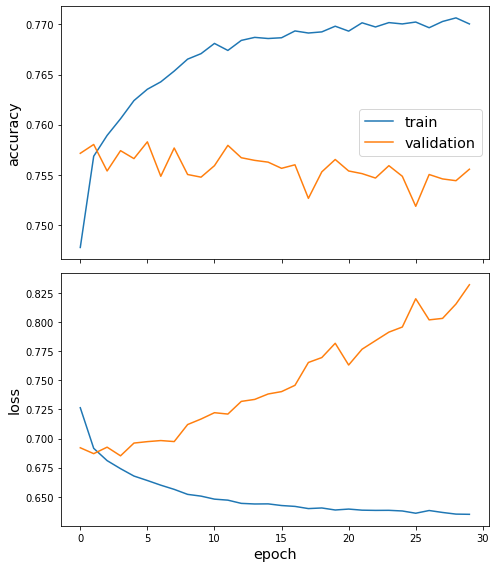

In [ ]:
sg.utils.plot_history(history)

In [ ]:
y_pred = model.predict(tf.convert_to_tensor(np.stack(X_test)))
y_pred = np.argmax(y_pred, axis=1)
y_pred = le.inverse_transform(y_pred)

y_pred[:10]

array(['Informatyka', 'Astronomia', 'Astronomia', 'Biologia',
       'Astronomia', 'Biologia', 'Astronomia', 'Matematyka', 'Fizyka',
       'Biologia'], dtype='<U11')

In [ ]:
y_test = np.array(y_test)
y_test = le.inverse_transform(y_test)

y_test[:10]

array(['Informatyka', 'Astronomia', 'Astronomia', 'Biologia',
       'Astronomia', 'Biologia', 'Astronomia', 'Matematyka', 'Biologia',
       'Biologia'], dtype='<U11')

In [ ]:
with open("/content/drive/Shareddrives/GCN-PROJECT/onehot140_base_y_pred.pickle", "wb") as f:
  pickle.dump(y_pred, f)
with open("/content/drive/Shareddrives/GCN-PROJECT/onehot140_base_y_true.pickle", "wb") as f:
  pickle.dump(y_test, f)

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

  Astronomia       0.98      0.96      0.97      3832
    Biologia       0.60      0.97      0.74      3522
      Chemia       0.68      0.26      0.38       416
      Fizyka       0.67      0.26      0.38       768
 Informatyka       0.74      0.41      0.53       738
  Matematyka       0.74      0.32      0.45      1211
 Psychologia       0.81      0.51      0.63       860

    accuracy                           0.75     11347
   macro avg       0.75      0.53      0.58     11347
weighted avg       0.78      0.75      0.73     11347



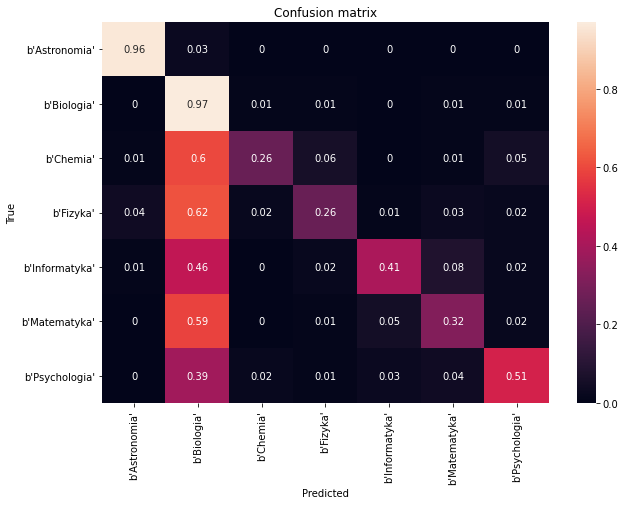

In [ ]:
conf_matrix(
    y_true=y_test,
    y_pred=y_pred
)

## GNN Models

### Data Preparation

In [ ]:
data_vec = data
node_data = data_vec[['title', 'doc_vec', 'category']]

features_columns = ['x'+str(i+1) for i in range(node_data.iloc[0]['doc_vec'].shape[0])]

node_data[features_columns] = pd.DataFrame(node_data['doc_vec'].tolist(), index=node_data.index)
node_data = node_data.drop_duplicates(subset=['title'])
node_data = node_data.set_index('title', drop=True)

node_subjects = node_data['category']
node_data = node_data.drop(columns=['doc_vec', 'category'])

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [ ]:
print(node_data.shape)
node_data.head()

(75649, 140)


,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,x18,x19,x20,x21,x22,x23,x24,x25,x26,x27,x28,x29,x30,x31,x32,x33,x34,x35,x36,x37,x38,x39,x40,...,x101,x102,x103,x104,x105,x106,x107,x108,x109,x110,x111,x112,x113,x114,x115,x116,x117,x118,x119,x120,x121,x122,x123,x124,x125,x126,x127,x128,x129,x130,x131,x132,x133,x134,x135,x136,x137,x138,x139,x140
title,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Mirosław_Miller,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Chimerokształtne,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
(2855)_Bastian,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Cryptocephalus_celtibericus,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Język_maszynowy,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
edges = pd.read_csv("/content/drive/Shareddrives/GCN-PROJECT/annotations.csv", header=None)
edges.columns = ['source', 'target']

nodes_set = set(node_data.index)
edges = edges[
    (edges['source'].isin(nodes_set)) &
    (edges['target'].isin(nodes_set))
]

In [ ]:
print(edges.shape)
edges.head()

(347655, 2)


,source,target
0,AWK,Język_programowania
2,AWK,System_operacyjny
3,AWK,Unix
4,AWK,Tablica_asocjacyjna
6,AWK,Wyrażenie_regularne


### StellarGraph

In [ ]:
stellar_graph = StellarGraph(
    {'article': node_data},
    {'annotation': edges}
)

In [ ]:
print(stellar_graph.info())

StellarGraph: Undirected multigraph
 Nodes: 75649, Edges: 347655

 Node types:
  article: [75649]
    Features: float32 vector, length 140
    Edge types: article-annotation->article

 Edge types:
    article-annotation->article: [347655]
        Weights: all 1 (default)
        Features: none


In [ ]:
print(set(node_subjects))
print(len(node_subjects))

{0, 1, 2, 3, 4, 5, 6}
75649


### Data preparation

In [ ]:
# split node_subjects to train and test_val
train_subjects, test_val_subjects = train_test_split(
    node_subjects, test_size=0.3, stratify=node_subjects, random_state=seed_value
)
# split test_val_subjects to test_subjects and val_subjects
test_subjects, val_subjects = train_test_split(
    test_val_subjects, test_size=0.5, stratify=test_val_subjects, random_state=seed_value
)
# 0.5 x 0.3 = 0.15

In [ ]:
print(f'Train: {len(train_subjects)}')
print(f'Test: {len(test_subjects)}')
print(f'Val: {len(val_subjects)}')

Train: 52954
Test: 11347
Val: 11348


In [ ]:
target_encoding = LabelBinarizer()

train_targets = target_encoding.fit_transform(train_subjects)
test_targets = target_encoding.transform(test_subjects)
val_targets = target_encoding.transform(val_subjects)

### GAT

In [ ]:
generator = FullBatchNodeGenerator(stellar_graph, method="gat")

train_gen = generator.flow(train_subjects.index, train_targets)
test_gen = generator.flow(test_subjects.index, test_targets)
val_gen = generator.flow(val_subjects.index, val_targets)

In [ ]:
# gat = GAT(
#     layer_sizes=[128, train_targets.shape[1]],
#     activations=["elu", "softmax"],
#     attn_heads=8,
#     generator=generator,
#     in_dropout=0.5,
#     attn_dropout=0.5,
#     normalize=None,
# )

gat = GAT(
    layer_sizes=[140, 140],
    activations=["elu", "elu"],
    attn_heads=8,
    generator=generator,
    in_dropout=0.5,
    attn_dropout=0.5,
    normalize=None,
)

In [ ]:
x_inp, x_out = gat.in_out_tensors()

dense = tf.keras.layers.Dense(units=70, activation="relu")(x_out)
predictions = tf.keras.layers.Dense(units=train_targets.shape[1], activation="softmax")(dense)

In [ ]:
model = Model(inputs=x_inp, outputs=predictions)

model.compile(
    optimizer=optimizers.Adam(lr=0.005),
    loss=losses.categorical_crossentropy,
    metrics=["acc"],
)

In [ ]:
# if not os.path.isdir("logs"):
#     os.makedirs("logs")
es_callback = EarlyStopping(
    monitor="val_acc", patience=20
)  # patience is the number of epochs to wait before early stopping in case of no further improvement
# mc_callback = ModelCheckpoint(
#     "logs/best_model.h5", monitor="val_acc", save_best_only=True, save_weights_only=True
# )

In [ ]:
history = model.fit(
    train_gen,
    epochs=100,
    validation_data=val_gen,
    verbose=2,
    shuffle=False,  # this should be False, since shuffling data means shuffling the whole graph
    # callbacks=[es_callback, mc_callback],
    # callbacks=[es_callback],
)

Epoch 1/100
1/1 - 7s - loss: 1.9953 - acc: 0.1168 - val_loss: 1.2012 - val_acc: 0.7124
Epoch 2/100
1/1 - 3s - loss: 1.1762 - acc: 0.6954 - val_loss: 0.8039 - val_acc: 0.7401
Epoch 3/100
1/1 - 3s - loss: 0.8424 - acc: 0.7136 - val_loss: 0.6906 - val_acc: 0.7889
Epoch 4/100
1/1 - 3s - loss: 0.7267 - acc: 0.7652 - val_loss: 0.5936 - val_acc: 0.8278
Epoch 5/100
1/1 - 3s - loss: 0.6512 - acc: 0.8031 - val_loss: 0.5231 - val_acc: 0.8456
Epoch 6/100
1/1 - 3s - loss: 0.5759 - acc: 0.8268 - val_loss: 0.4814 - val_acc: 0.8512
Epoch 7/100
1/1 - 3s - loss: 0.5434 - acc: 0.8306 - val_loss: 0.4478 - val_acc: 0.8594
Epoch 8/100
1/1 - 3s - loss: 0.5155 - acc: 0.8363 - val_loss: 0.4285 - val_acc: 0.8620
Epoch 9/100
1/1 - 3s - loss: 0.5194 - acc: 0.8313 - val_loss: 0.4144 - val_acc: 0.8667
Epoch 10/100
1/1 - 3s - loss: 0.4796 - acc: 0.8463 - val_loss: 0.4102 - val_acc: 0.8658
Epoch 11/100
1/1 - 3s - loss: 0.4779 - acc: 0.8481 - val_loss: 0.4070 - val_acc: 0.8672
Epoch 12/100
1/1 - 3s - loss: 0.4775 - ac

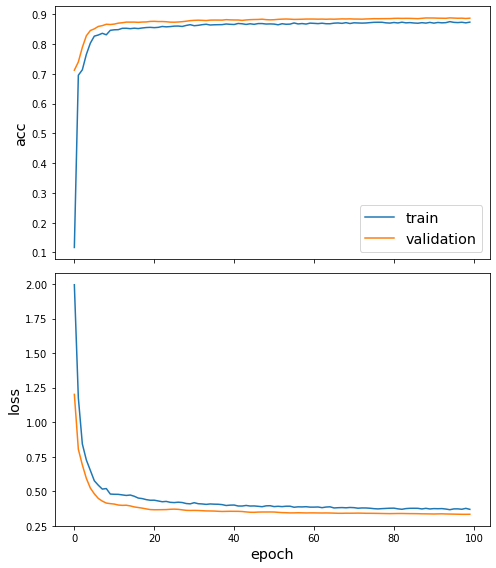

In [ ]:
sg.utils.plot_history(history)

In [ ]:
test_metrics = model.evaluate(test_gen)

print("\nTest Set Metrics:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

1/1 [==============================] - 1s 714ms/step - loss: 0.3336 - acc: 0.8878

Test Set Metrics:
	loss: 0.3336
	acc: 0.8878


In [ ]:
y_pred = model.predict(test_gen)
y_pred = target_encoding.inverse_transform(y_pred.squeeze())
y_pred = le.inverse_transform(y_pred)

y_pred[:10]

array(['Informatyka', 'Astronomia', 'Astronomia', 'Biologia',
       'Astronomia', 'Biologia', 'Astronomia', 'Matematyka', 'Biologia',
       'Biologia'], dtype='<U11')

In [ ]:
y_test = target_encoding.inverse_transform(test_targets)
y_test = le.inverse_transform(y_test)

y_test[:10]

array(['Informatyka', 'Astronomia', 'Astronomia', 'Biologia',
       'Astronomia', 'Biologia', 'Astronomia', 'Matematyka', 'Biologia',
       'Biologia'], dtype='<U11')

In [ ]:
with open("/content/drive/Shareddrives/GCN-PROJECT/onehot140_gat_y_pred.pickle", "wb") as f:
  pickle.dump(y_pred, f)
with open("/content/drive/Shareddrives/GCN-PROJECT/onehot140_gat_y_true.pickle", "wb") as f:
  pickle.dump(y_test, f)

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

  Astronomia       0.98      0.99      0.98      3832
    Biologia       0.88      0.97      0.92      3522
      Chemia       0.71      0.53      0.61       416
      Fizyka       0.79      0.69      0.74       768
 Informatyka       0.77      0.75      0.76       738
  Matematyka       0.81      0.75      0.78      1211
 Psychologia       0.85      0.74      0.79       860

    accuracy                           0.89     11347
   macro avg       0.83      0.78      0.80     11347
weighted avg       0.88      0.89      0.88     11347



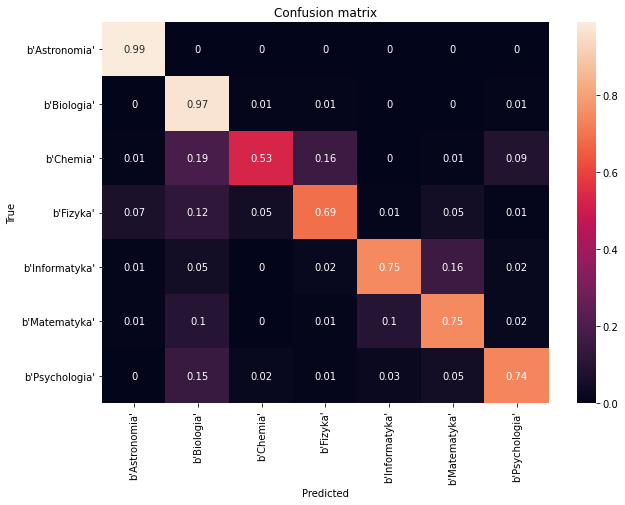

In [ ]:
conf_matrix(
    y_true=y_test,
    y_pred=y_pred
)

### GCN

In [ ]:
generator = FullBatchNodeGenerator(stellar_graph, method="gcn")

train_gen = generator.flow(train_subjects.index, train_targets)
test_gen = generator.flow(test_subjects.index, test_targets)
val_gen = generator.flow(val_subjects.index, val_targets)

Using GCN (local pooling) filters...


In [ ]:
gcn = GCN(
    layer_sizes=[140, 140],
    activations=["elu", "elu"],
    generator=generator,
    dropout=0.5
)

In [ ]:
x_inp, x_out = gcn.in_out_tensors()

dense = tf.keras.layers.Dense(units=70, activation="relu")(x_out)
predictions = tf.keras.layers.Dense(units=train_targets.shape[1], activation="softmax")(dense)

In [ ]:
model = Model(inputs=x_inp, outputs=predictions)

model.compile(
    optimizer=optimizers.Adam(lr=0.005),
    loss=losses.categorical_crossentropy,
    metrics=["acc"],
)

In [ ]:
# if not os.path.isdir("logs"):
#     os.makedirs("logs")
es_callback = EarlyStopping(
    monitor="val_acc", patience=20
)  # patience is the number of epochs to wait before early stopping in case of no further improvement
# mc_callback = ModelCheckpoint(
#     "logs/best_model.h5", monitor="val_acc", save_best_only=True, save_weights_only=True
# )

In [ ]:
history = model.fit(
    train_gen,
    epochs=100,
    validation_data=val_gen,
    verbose=2,
    shuffle=False,  # this should be False, since shuffling data means shuffling the whole graph
    # callbacks=[es_callback, mc_callback],
    # callbacks=[es_callback],
)

Epoch 1/100
1/1 - 1s - loss: 1.9926 - acc: 0.0798 - val_loss: 1.7666 - val_acc: 0.6880
Epoch 2/100
1/1 - 0s - loss: 1.7614 - acc: 0.6489 - val_loss: 1.5842 - val_acc: 0.6901
Epoch 3/100
1/1 - 0s - loss: 1.5910 - acc: 0.6790 - val_loss: 1.3732 - val_acc: 0.6865
Epoch 4/100
1/1 - 0s - loss: 1.4054 - acc: 0.6785 - val_loss: 1.1657 - val_acc: 0.6858
Epoch 5/100
1/1 - 0s - loss: 1.1651 - acc: 0.6776 - val_loss: 1.0019 - val_acc: 0.6863
Epoch 6/100
1/1 - 0s - loss: 1.0136 - acc: 0.6807 - val_loss: 0.8950 - val_acc: 0.6895
Epoch 7/100
1/1 - 0s - loss: 0.9121 - acc: 0.6846 - val_loss: 0.8338 - val_acc: 0.6950
Epoch 8/100
1/1 - 0s - loss: 0.8523 - acc: 0.6929 - val_loss: 0.7922 - val_acc: 0.7105
Epoch 9/100
1/1 - 0s - loss: 0.8176 - acc: 0.7065 - val_loss: 0.7493 - val_acc: 0.7351
Epoch 10/100
1/1 - 0s - loss: 0.7732 - acc: 0.7293 - val_loss: 0.7081 - val_acc: 0.7639
Epoch 11/100
1/1 - 0s - loss: 0.7350 - acc: 0.7541 - val_loss: 0.6798 - val_acc: 0.7789
Epoch 12/100
1/1 - 0s - loss: 0.7133 - ac

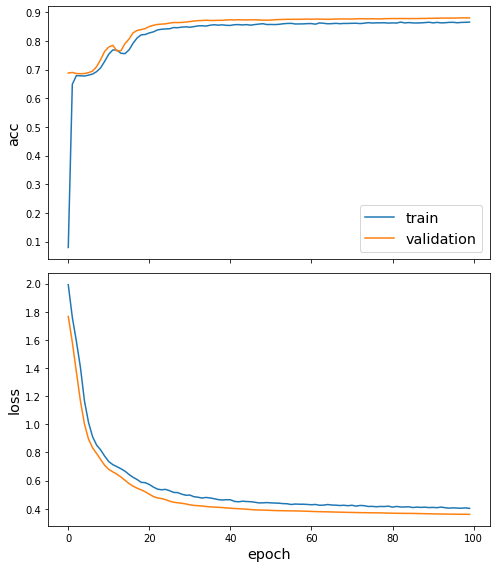

In [ ]:
sg.utils.plot_history(history)

In [ ]:
test_metrics = model.evaluate(test_gen)

print("\nTest Set Metrics:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

1/1 [==============================] - 0s 96ms/step - loss: 0.3599 - acc: 0.8827

Test Set Metrics:
	loss: 0.3599
	acc: 0.8827


In [ ]:
y_pred = model.predict(test_gen)
y_pred = target_encoding.inverse_transform(y_pred.squeeze())
y_pred = le.inverse_transform(y_pred)

y_pred[:10]

array(['Informatyka', 'Astronomia', 'Astronomia', 'Biologia',
       'Astronomia', 'Biologia', 'Astronomia', 'Matematyka', 'Biologia',
       'Biologia'], dtype='<U11')

In [ ]:
y_test = target_encoding.inverse_transform(test_targets)
y_test = le.inverse_transform(y_test)

y_test[:10]

array(['Informatyka', 'Astronomia', 'Astronomia', 'Biologia',
       'Astronomia', 'Biologia', 'Astronomia', 'Matematyka', 'Biologia',
       'Biologia'], dtype='<U11')

In [ ]:
with open("/content/drive/Shareddrives/GCN-PROJECT/onehot140_gcn_y_pred.pickle", "wb") as f:
  pickle.dump(y_pred, f)
with open("/content/drive/Shareddrives/GCN-PROJECT/onehot140_gcn_y_true.pickle", "wb") as f:
  pickle.dump(y_test, f)

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

  Astronomia       0.99      0.99      0.99      3832
    Biologia       0.88      0.97      0.92      3522
      Chemia       0.65      0.55      0.60       416
      Fizyka       0.77      0.70      0.74       768
 Informatyka       0.75      0.74      0.74       738
  Matematyka       0.82      0.73      0.77      1211
 Psychologia       0.83      0.73      0.78       860

    accuracy                           0.88     11347
   macro avg       0.81      0.77      0.79     11347
weighted avg       0.88      0.88      0.88     11347



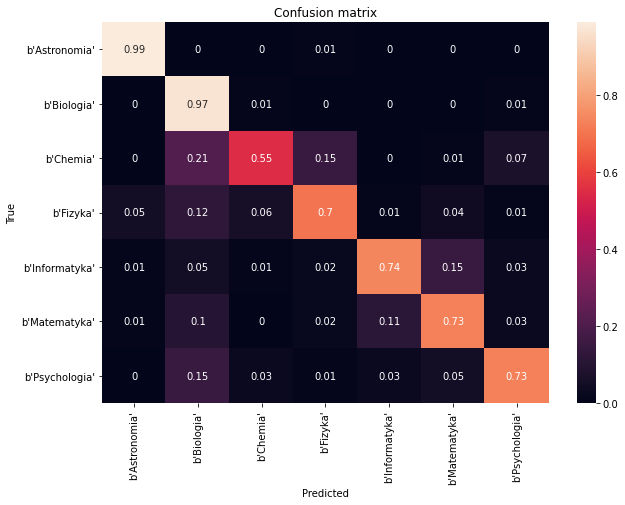

In [ ]:
conf_matrix(
    y_true=y_test,
    y_pred=y_pred
)